In [1]:
import argparse
import torch
import yaml

from eval.evaluator import Evaluator
from data.loaders import CxrDataLoader
from configs import load_config_from_file

/Users/tudormihaita/PycharmProjects/clip-cxr-report-gen/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tudormihaita/PycharmProjects/clip-cxr-report-gen/.venv/lib/python3.9/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tudormihaita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tudormihaita/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading packa

In [5]:
prompts_path = "./output/train_prompts_all.json"
checkpoint_path = "./output/finetune/clip-xrgen-classifier_best_auroc.tar"
# checkpoint_path = "./output/clip-xrgen-pretrained-mscl.pt"
# checkpoint_path = "./output/generation/clip-xrgen_best_loss.pt"
tokenizer_config_path = "../configs/tokenizer/clinical_bert.yaml"
transform_config_path = "../configs/transform/clahe.yaml"

clip_model_path = "../configs/model/clip_swin_clinical.yaml"
generate_model_path = "../configs/model/conditional_report_gen.yaml"
classifier_model_path = "../configs/model/swin_classification.yaml"

clip_loss_path = "../configs/loss/contrastive.yaml"
generate_loss_path = "../configs/loss/language_modeling.yaml"
classifier_loss_path = "../configs/loss/classification.yaml"

In [6]:
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
print(checkpoint['model_state_dict'].keys())

odict_keys(['image_encoder.image_encoder.embeddings.patch_embeddings.projection.weight', 'image_encoder.image_encoder.embeddings.patch_embeddings.projection.bias', 'image_encoder.image_encoder.embeddings.norm.weight', 'image_encoder.image_encoder.embeddings.norm.bias', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.layernorm_before.weight', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.layernorm_before.bias', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.relative_position_index', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.query.weight', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.query.bias', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.key.weight', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.key.bias', 'image_encoder.image_encoder.encoder.laye

In [3]:
evaluator = Evaluator(
    model_config_path=generate_model_path,
    loss_config_path=generate_loss_path,
    tokenizer_config_path=tokenizer_config_path,
    train_prompts_path=prompts_path,
    ckpt_path=checkpoint_path
)

2025-06-11 02:43:04,975 - INFO - Loading pre-trained image encoder weights
2025-06-11 02:43:05,915 - INFO - Freezing image encoder to not be re-trained


In [6]:
transform_config = load_config_from_file(transform_config_path)

args = argparse.Namespace(
    dataset_name='mimic-cxr-mvs',
    batch_size=4,
    max_length=128,
    image_size=224,
    num_workers=0,
    drop_last=True,
    use_minio=False
)

dataloader = CxrDataLoader(
    args,
    split='test',
    transform_config=transform_config,
    tokenizer=evaluator.tokenizer,
)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tudormihaita/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = evaluator.model.to(device)
model.eval()


batch = next(iter(dataloader))  # Get one batch
images = batch['images'].to(device)
findings = batch['labels']  # Assuming this is needed for generation
references = batch['texts']

# Generate predictions
predictions = model.generate(
    images=images,
    findings=findings,
    temperature=1.0,
    repetition_penalty=1.4,
    device=device
)

# Display 2 samples
for i in range(min(2, len(predictions))):
    print(f"\nSample {i+1}")
    print(f"Reference:   {references[i]}")
    print(f"Prediction:  {predictions[i]}")
    print("-" * 80)


Sample 1
Reference:   There is a cardiomediastinal silhouette, position of the NG tube, vascular stents projecting over the left upper mediastinum as well as interstitial opacities and pleural calcifications. AP chest: Upper enteric drainage tube ends in the distal duodenum.
Prediction:  No abnormal findings ap chest : lungs are fully expanded and clear. cardiomediastinal and hilar silhouettes and pleural surfaces are normal. there is no appreciable Pleural Effusion or evidence of central lymph node enlargement. right jugular line ends low in the svc. no Pneumothorax or mediastinal vascular engorgement. heart size top - normal. notification : dr. _ _ _ reported the findings to dr _ _ by telephone on _ _ at 11 : 00 am, 2 minutes after discovery of the findings. 5 minutes discovery of these findings.
--------------------------------------------------------------------------------

Sample 2
Reference:   NGT ends in the fundus of a moderately to severely distended stomach. Dobbhoff cathet

Extracting embeddings: 100%|██████████| 725/725 [03:39<00:00,  3.31it/s]


Computing t-SNE for 14 findings: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.000s...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[t-SNE] Computed neighbors for 2900 samples in 0.166s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 0.350289
[t-SNE] KL divergence after 250 iterations wi

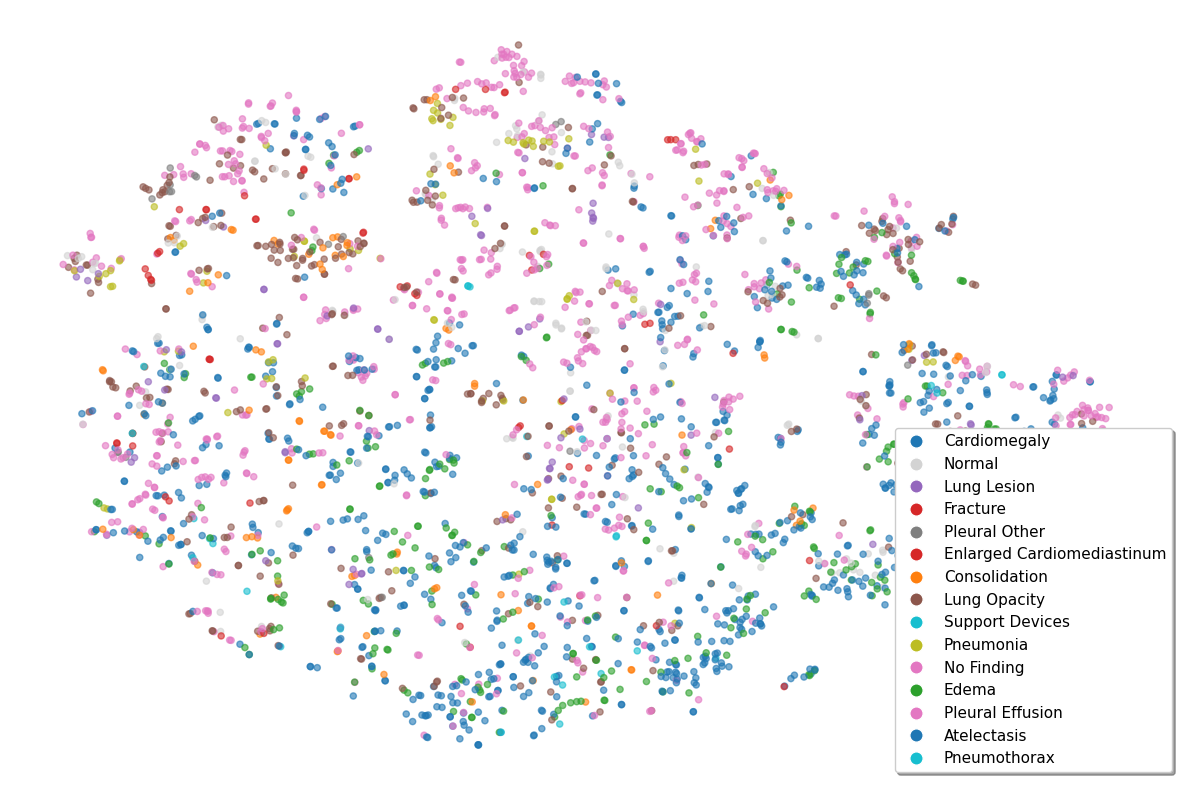

Evaluation metrics: {
  "r_mean": 123.61344827586207,
  "recall@1": 4.793103448275862,
  "recall@5": 16.17241379310345,
  "recall@10": 25.137931034482758,
  "precision@1": 48.36577304443628,
  "precision@5": 47.39625413147264,
  "precision@10": 46.55159750275432,
  "valid_queries": 2723,
  "total_samples": 2900,
  "num_classes": 14,
  "precision@1_avg": 34.53729012104647,
  "precision@5_avg": 33.10816087465834,
  "precision@10_avg": 32.27840687231551,
  "total_queries": 5122,
  "per_class": {
    "Atelectasis": {
      "precision@1": 25.74712643678161,
      "precision@5": 21.379310344827587,
      "precision@10": 20.413793103448274,
      "num_queries": 435
    },
    "Cardiomegaly": {
      "precision@1": 30.978260869565215,
      "precision@5": 28.913043478260875,
      "precision@10": 27.409420289855074,
      "num_queries": 552
    },
    "Consolidation": {
      "precision@1": 17.791411042944784,
      "precision@5": 14.846625766871169,
      "precision@10": 13.865030674846626,
 

In [5]:
eval_metrics = evaluator.evaluate(dataloader, metrics='retrieval')

# Other experiments

In [8]:
model = model.eval()
sample = next(iter(dataloader))
image = sample["images"][0]
caption = sample["texts"][0]
labels = sample["labels"][0]

print(f"Image shape: {image.shape}")
print(f"Caption: {caption}")

labels = labels.unsqueeze(0)  # add batch dimension
image = image.unsqueeze(0)  # add batch dimension
image_embeds = model.encode_image(image)


generated_caption = model.generate(
    image_embeds,
    labels
)

print(f"Generated Caption: {generated_caption}")

Image shape: torch.Size([3, 224, 224])
Caption: There is a cardiomediastinal silhouette, position of the NG tube, vascular stents projecting over the left upper mediastinum as well as interstitial opacities and pleural calcifications. AP chest: Upper enteric drainage tube ends in the distal duodenum.
Generated Caption: ['Indication: Chest X-ray showing No Found, Support Devices. Findings: Â']


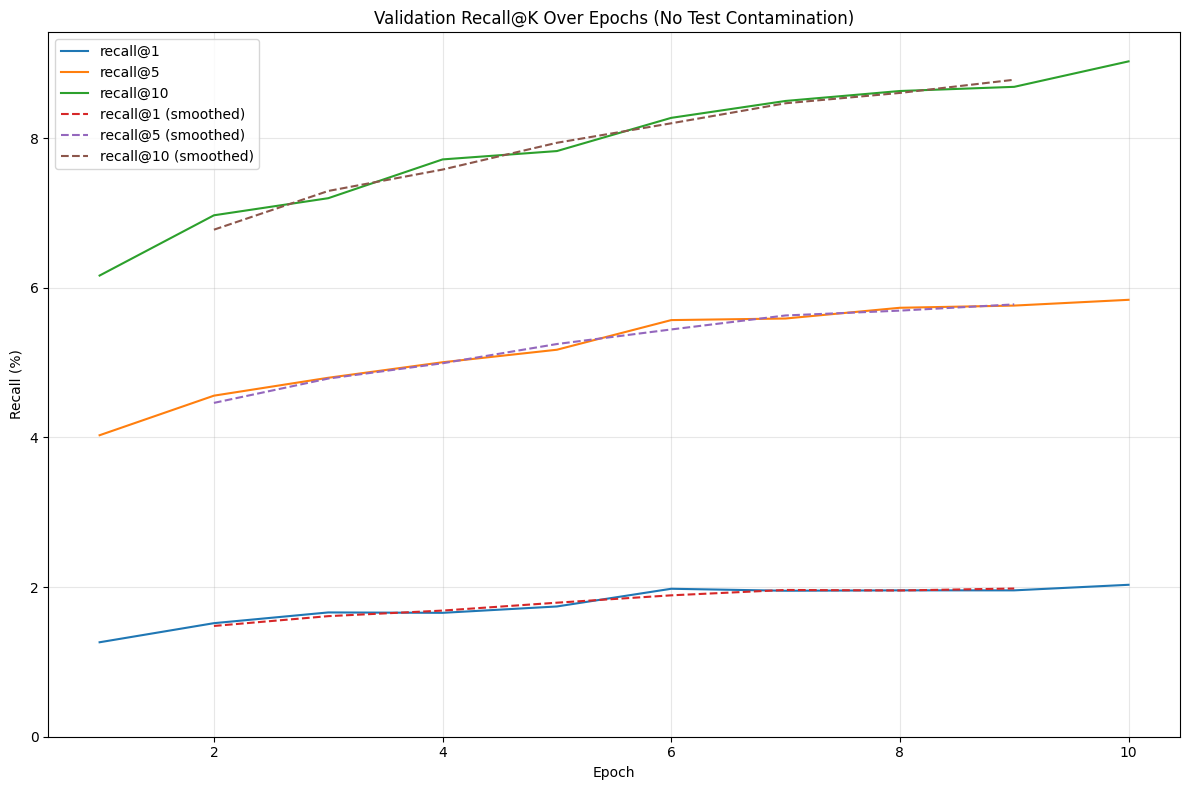

In [2]:
import matplotlib.pyplot as plt
import numpy as np

steps = list(range(1, 11))
recall_at_1 = [
    1.2622, 1.5173, 1.6608, 1.6555, 1.7405,
    1.9770, 1.9505, 1.9558, 1.9558, 2.0302
]
recall_at_5 = [
    4.0285, 4.5573, 4.7964, 5.0037, 5.1711,
    5.5671, 5.5883, 5.7318, 5.7611, 5.8381
]
recall_at_10 = [
    6.1623, 6.9675, 7.1960, 7.7142, 7.8258,
    8.2696, 8.4954, 8.6283, 8.6841, 9.0242
]

plt.figure(figsize=(12, 8))
plt.plot(steps, recall_at_1, label='recall@1')
plt.plot(steps, recall_at_5, label='recall@5')
plt.plot(steps, recall_at_10, label='recall@10')

def smooth(values, window=3):
    if len(values) < window:
        return values
    kernel = np.ones(window) / window
    return np.convolve(values, kernel, mode='valid')

plt.plot(steps[1:-1], smooth(recall_at_1), '--', label='recall@1 (smoothed)')
plt.plot(steps[1:-1], smooth(recall_at_5), '--', label='recall@5 (smoothed)')
plt.plot(steps[1:-1], smooth(recall_at_10), '--', label='recall@10 (smoothed)')

plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Recall (%)')
plt.title('Validation Recall@K Over Epochs (No Test Contamination)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
import torch
import random
import argparse
import numpy as np
from PIL import Image

from constants import CHEXPERT_LABELS
from data.datasets import MimicCxrMVSDataset
from api.pipeline import CLIPXRGenPipeline

MODEL_PATH = "../api/models/clip-xrgen-bert.pt"
CONFIG_PATH = "../api/configs/clip_xrgen_config.yaml"

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = '../api/' + MODEL_PATH
CONFIG_PATH = '../api/' + CONFIG_PATH
DATASET_NAME = 'mimic-cxr-mvs'
NUM_SAMPLES = 10

try:
    pipeline = CLIPXRGenPipeline.from_pretrained(
        model_path=MODEL_PATH,
        config_path=CONFIG_PATH,
        device=DEVICE
    )
    print(f"Model info: {pipeline.model_info}")
except Exception as e:
    print(f"Error loading pipeline: {e}")
    raise


args = argparse.Namespace(
    dataset_name='mimic-cxr-mvs',
    batch_size=10,
    max_length=128,
    image_size=224,
    num_workers=0,
    drop_last=True,
    use_minio=False
)

test_transform = pipeline.transform
test_dataset = MimicCxrMVSDataset(args, 'test', test_transform, use_minio=False)

test_indices = random.sample(range(len(test_dataset)), min(NUM_SAMPLES, len(test_dataset)))
print(f"Selected {len(test_indices)} random test samples: {test_indices}")

for i, idx in enumerate(test_indices):
    sample = test_dataset[idx]

    uid = sample['uid']
    image_tensor = sample['image']
    ground_truth = sample['text']
    gt_labels = sample['labels'].numpy()

    image_np = image_tensor.permute(1, 2, 0).numpy()
    image_np = (image_np * 0.5 + 0.5)
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8))

    print(f"\n--- Sample {i+1} (uid: {uid}) ---")

    gt_positive = [CHEXPERT_LABELS[j] for j, val in enumerate(gt_labels) if val == 1]
    print(f"Ground-truth labels: {gt_positive}")

    prediction = pipeline(image_pil)

    print(f"\nGround Truth Reference:\n{ground_truth}")
    print(f"\nPrediction:\n{prediction}")
    print("-" * 60)

2025-06-15 12:47:02,610 - INFO - Loading pre-trained image encoder weights
2025-06-15 12:47:04,269 - INFO - Freezing image encoder to not be re-trained
2025-06-15 12:47:04,343 - INFO - Loading pre-trained weights
2025-06-15 12:47:04,403 - INFO - Loaded model weights successfully
2025-06-15 12:47:04,403 - INFO - Freezing model weights


Model info: {'model_name': 'CLIPXRGen', 'version': '1.0', 'description': 'CLIP-based X-ray report generation model', 'device': 'cpu', 'vocab_size': 29016, 'num_parameters': 165132128, 'config': {'tokenizer': {'source': 'huggingface', 'pretrained_model_name_or_path': 'emilyalsentzer/Bio_ClinicalBERT', 'cache_dir': 'huggingface/tokenizers'}, 'transform': {'inference': {'Resize': {'size': 224}, 'CenterCrop': {'size': 224}}}, 'encoder': {'model': {'name': 'finetune_classifier', 'load_backbone_weights': '../api/models/clip-xrad-backbone-swin224.pt', 'freeze_backbone_weights': True, 'image_encoder': {'source': 'huggingface', 'name': 'microsoft/swin-tiny-patch4-window7-224', 'pretrained': True, 'model_type': 'swin'}, 'classifier': {'config': {'name': 'mlp', 'hidden_dim': 384, 'n_class': 14}}}, 'loss': {'classification': None, 'loss_ratio': 1.0, 'contrastive_mcsl': {'semantic_temperature': 1.0, 'semantic_weight': 0.7, 'loss_ratio': 1.0}}}, 'decoder': {'model': {'name': 'downstream_decoder', 'l

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tudormihaita/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



--- Sample 1 (uid: 4331c9eb-f6e0c046-8c50bffc-6f363a16-02f0f87f) ---
Ground-truth labels: ['Atelectasis', 'Enlarged Cardiomediastinum', 'Pleural Effusion']

Ground Truth Reference:
Small bilateral effusions with adjacent atelectasis Right IJ catheter tip in the proximal right atrium Small bilateral effusions with adjacent atelectasis Right IJ catheter tip in the proximal right atrium

Prediction:
Atelectasis, Enlarged Cardiomediastinum, Fracture, Pleural Effusion, Pneumothorax, Support Devices 1. right chest tube in place. there is no evidence of a Pneumothorax. the right hemidiaphragmatic contour and of the mediastinum, consistent with pleural thickening. small right Pleural Effusion and left basilar Atelectasis. no pulmonary Edema. cardiac and mediastinal contours stable.
------------------------------------------------------------

--- Sample 2 (uid: ae7fb131-28d05c98-90cbbc4c-f05c219a-1d0fed84) ---
Ground-truth labels: ['Atelectasis', 'Cardiomegaly', 'Pleural Effusion', 'Support D